# Lab 3: Extending Logistic Regression 

##Intent classification with the CLINC150 Dataset 

Team:

Jaryd Domine

Sharon Yang

##1. Preparation and overview

### Overview

The dataset we selected is **CLINC150 Data Set** downloaded from https://archive.ics.uci.edu/ml/datasets/CLINC150#.

This is an **intent classification** dataset. It consists of only two columns:
1. *queries*: strings, e.g. "what is the weather today"
2. *intents*: strings, e.g. "weather"

The objective for this dataset is to match a query to an appropriate intent, e.g. if a user says "please call Amy," the intent should be matched to "make_call." We already have the queries as text; in an application, this would come next in the chain after some speech-to-text algorithm.

Task-oriented dialog systems (Alexa, Google assistant, etc.) allow people to interact with machines using natural language to accomplish specific tasks. The marketability of such systems is already well established, and for good reason. Simply *asking* your device to perform some task is faster, more natural, and more accessible than performing some sequence of taps or clicks.

To perform the requested task, the system needs to getermine what sort of task is being requested, i.e. the "intent." A machine learning model will in some way base its decision off of keywords and structural patterns of the spoken query.

In this lab, we classify a subset of 10 common intents from the in the whole system which could be used for offline analysis.

---


What follows is a summary of our work.

In the full dataset, there are 150 intent categories and an additional "out-of-scope" category. There are 4 versions of the dataset and we use the **data_full.json** version: each of the 150 in-domain intent classes has 100 train, 20 validation, and 30 test samples; the out-of-scope ("oos") class has 100 train, 100 validation, and 1,000 test samples.

We resample the data into an 80/20 split with no validation set.

The whole dataset is in text format. To use logistic regression, we first vectorize the queries using sklearn's **TfidfVectorizer**. Each query becomes a vector in $\mathbb{R}^N$, where $N$ is the number of unique words across all queries.

To improve performance, we then reduce the dimension of the vectors with sklearn's **TruncatedSVD**. The number of dimensions remaining is left a hyperparameter, here chosen to be 10.

Initial testing with all 151 intents (categories) showed very poor accuracy, almost as bad as random guessing. We have thus reduced the number of classes by selecting 10 common, distinct intents:
```
intents_keep = ['translate','time','date','weather','yes','no',
                'make_call','alarm','traffic','directions']
```
We then adapt the logistic classification classes from the class notebook. Four in-class solvers are used:
* Line search
* Stochastic gradient descent
* Newton's method
* BFGS

We also implement a custom class with a choice of three techniques:
* L1-regularized steepest ascent
* L1-regularized stochastic gradient descent
* L1-regularized Newton's method

All have been updated to use L1 regularization with parameter C.

We perform a grid search on all four solvers and a logarithmic range of C values from $10^{-6}$ to $1$. We do the same for 5 solvers from scikit-learn.

We select the best choice of solver and C value from our solvers and from scikit-learn, and compare the two both in time and accuracy.

---

As for which model is deemed best, it may seem that speed is an important factor. *But*, we mean speed of response, not necessarily speed of training. The deployed model ***does not need to adapt to a specific user as much as a speech-to-text model would***. If two people say "what's the weather" in vasty different accents, our model will not notice a difference unless the speech-to-text model fails to output the same query. Some adaptation is necessary, but since these models will adapt to each user over the course of weeks or more, speed is not so relevant here.

We thus choose the model based primarily on **accuracy** and not speed (within reason).

---

For our exceptional work, we implement an optimization technique for logistic regression using mean square error (MSE) as our objective function. We derive the gradient updates for the Hessian and use Newton's method to update the values of **w**.

Related Paper: Stefan Larson, Anish Mahendran, Joseph J. Peper, Christopher Clarke, Andrew Lee, Parker Hill, Jonathan K. Kummerfeld, Kevin Leach, Michael A. Laurenzano, Lingjia Tang, and Jason Mars. 2019. **"An evaluation dataset for intent classification and out-of-scope prediction."** In Proceedings of EMNLP-IJCNLP.
https://www.aclweb.org/anthology/D19-1131/





###Data preparation

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/clinc150_uci/data_full.json') as f:
    j  = json.load(f)
    print(j.keys())

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])


We load the data. It has been pre-split into train, test, and validation.

We join all sets to later make our own 80-20 split.

In [ ]:
subsets = ['val', 'train', 'test']
# subsets_oos = ['oos_val', 'oos_test', 'oos_train']

df = pd.concat([pd.DataFrame(j[subset]) for subset in subsets])
df.reset_index(inplace=True,drop=True)

#label columns
df.columns = ['queries','intents']

#format queries
df.queries = df.queries.str.replace('[^a-z ]','')

We have ignored the out-of-scope "oos" queries & intents as we will be using only a subset of all 151 classes.

Below we list all 150 intents, excluding our-of-scope:

In [ ]:
df.intents.unique()

array(['translate', 'transfer', 'timer', 'definition', 'meaning_of_life',
       'insurance_change', 'find_phone', 'travel_alert', 'pto_request',
       'improve_credit_score', 'fun_fact', 'change_language', 'payday',
       'replacement_card_duration', 'time', 'application_status',
       'flight_status', 'flip_coin', 'change_user_name',
       'where_are_you_from', 'shopping_list_update', 'what_can_i_ask_you',
       'maybe', 'oil_change_how', 'restaurant_reservation', 'balance',
       'confirm_reservation', 'freeze_account', 'rollover_401k',
       'who_made_you', 'distance', 'user_name', 'timezone', 'next_song',
       'transactions', 'restaurant_suggestion', 'rewards_balance',
       'pay_bill', 'spending_history', 'pto_request_status',
       'credit_score', 'new_card', 'lost_luggage', 'repeat', 'mpg',
       'oil_change_when', 'yes', 'travel_suggestion', 'insurance',
       'todo_list_update', 'reminder', 'change_speed', 'tire_pressure',
       'no', 'apr', 'nutrition_info', 'c

The 150 intent classes are labelled by their topic, such as "translate", "card_declined", etc. We picked 10 classes: 'translate', 'time', 'date', 'weather', 'yes', 'no', 'make_call', 'alarm', 'traffic', 'directions.' These were selected for their ubiquity and span a wide range of tasks.

In [ ]:
intents_keep = ['translate','time','date','weather','yes','no',
                'make_call','alarm','traffic','directions']

#define a decoder for use with the solvers
int_to_intent = { i:intent for i,intent in enumerate(intents_keep)}

df = df[df.intents.isin(intents_keep)].reset_index(drop=True)
df

,queries,intents
0,in spanish meet me tomorrow is said how,translate
1,in french how do i say see you later,translate
2,how do you say hello in japanese,translate
3,how do i ask about the weather in chinese,translate
4,how can i say cancel my order in french,translate
...,...,...
1495,on the way to work is there traffic,traffic
1496,is there traffic on the way to work,traffic
1497,will i encounter traffic,traffic
1498,is there traffic on the way,traffic


We check for invalid queries (containing no words), the equivalent of NaN for this dataset. We drop these rows.

In [ ]:
df['numwords'] = [len(query.split()) for query in df.queries]
df[df.numwords == 0]

df.drop(np.where(df.numwords==0)[0], inplace=True)
df.reset_index(inplace=True,drop=True)
df

,queries,intents,numwords
0,in spanish meet me tomorrow is said how,translate,8
1,in french how do i say see you later,translate,9
2,how do you say hello in japanese,translate,7
3,how do i ask about the weather in chinese,translate,9
4,how can i say cancel my order in french,translate,9
...,...,...,...
1494,on the way to work is there traffic,traffic,8
1495,is there traffic on the way to work,traffic,8
1496,will i encounter traffic,traffic,4
1497,is there traffic on the way,traffic,6


There are 1499 rows remaining.

###Vectorization and decomposition

We use scikit's TfidfVectorizer.

A total of 930 unique words are present in the corpus, thus each query is made into a 930-dimensional vector.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer#CountVectorizer

corpus = list(df.queries)

cv = TfidfVectorizer()#CountVectorizer()
Xhi  = cv.fit_transform(corpus)
an = cv.build_analyzer()
# cv.get_feature_names()
print(len(Xhi.toarray()[0]))
print([i for i in Xhi.toarray()[0]])

930
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

We lower the dimensionality via scikit's TruncatedSVD to improve training speed.

We choose to retain 10 dimensions.

In [ ]:
from sklearn.decomposition import TruncatedSVD

N_FEATURES = 10

svd = TruncatedSVD(n_components=N_FEATURES,random_state=0)
Xlo = svd.fit_transform(Xhi)

###Visualization of vectorized queries with UMAP

In [ ]:
!pip install -q umap-learn
!pip install -q umap-learn[plot]
import umap
import umap.plot

####UMAP on subset of 10 classes

We visualize a UMAP mapping to 2D from the 10D dataset.

In [ ]:
%%time
mapper = umap.UMAP().fit(Xlo)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


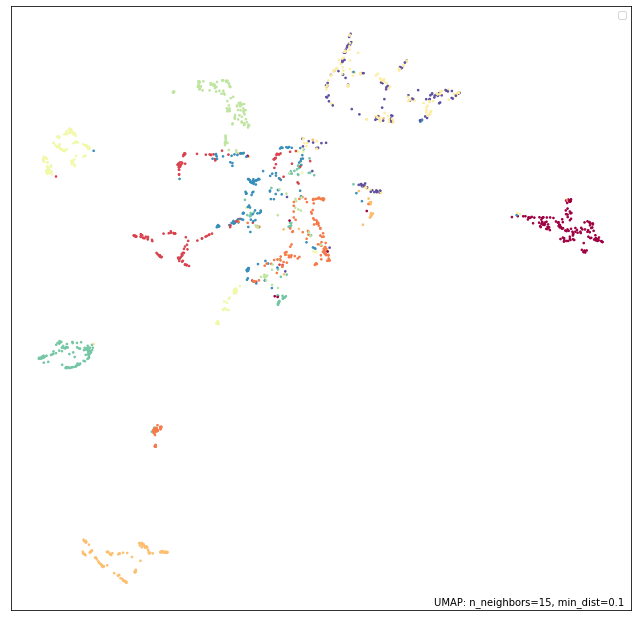

In [ ]:
umap.plot.points(mapper,labels=df.intents)
plt.legend('')

One may have guessed that some intent types overlap quite a bit in the vocabulary of their queries. For example, the queries
> what is the weather today?

> what is the date today?

crucially share the word "today," which, from our tfidf vectorization, is much higher value than the words in "what is the." These two queries correspond to different intents, obviously, but there's bound to be some confusion for our model.

These similarities in query vocabulary and the potential for confusion may be associated with the overlapping of clusters we see from UMAP.

The clustering here shows promise; the outlying groups should have little confusion, while there is some potential overlap in that central cluster.

####UMAP with all 151 classes (including out-of-scope)

We also plot the full dataset with 151 classes, both using the reduced- and full-dimension dataframes.

In [ ]:
%%time
mapper = umap.UMAP(n_neighbors=100).fit(Xlo)

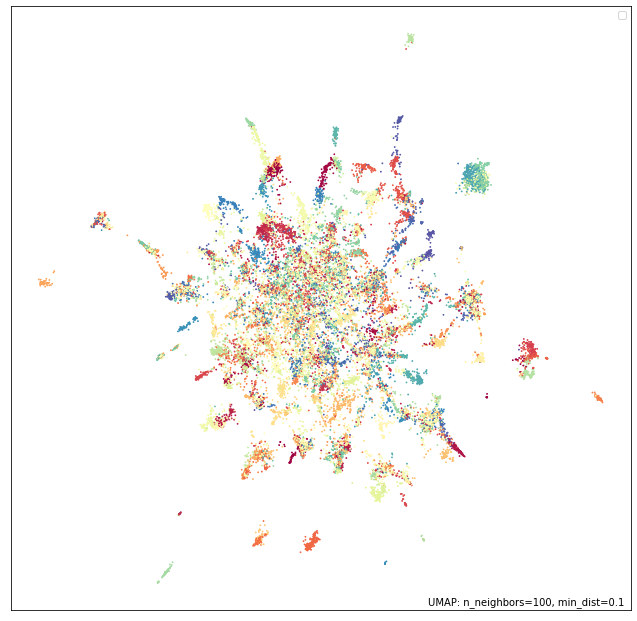

In [ ]:
umap.plot.points(mapper,labels=df.intents)
plt.legend('')

In [ ]:
%%time
mapperfull = umap.UMAP(n_neighbors=100).fit(Xhi)

CPU times: user 4min 33s, sys: 2.29 s, total: 4min 36s
Wall time: 2min 23s


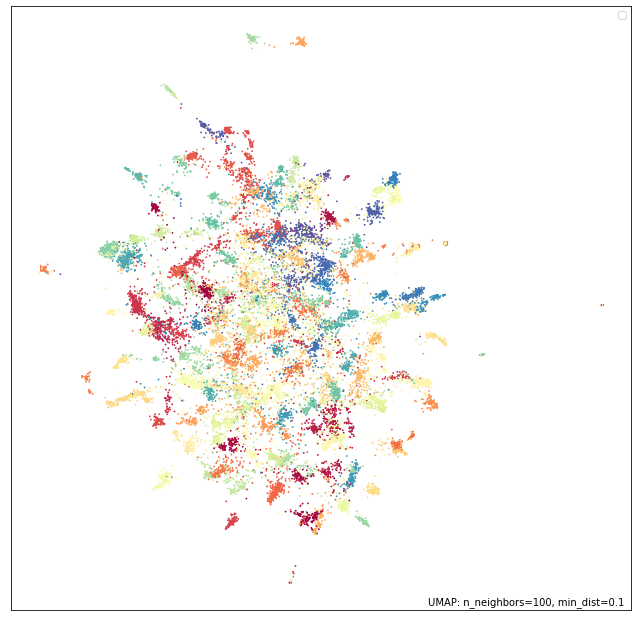

In [ ]:
umap.plot.points(mapperfull,labels=df.intents)
plt.legend('')

This last mapping used all 151 classes (including out-of-scope) with the full- (over 7000) dimensional vectorized queries.

###Train-test split

Since the original version of the dataset has 100 training, 20 validation and 30 test samples, which is quite close to 80% and 20% testing split, we agree splitting the data using 80/20 split. Instead of using the split of the original data, we will combine them all together and divide them into 80/20 split. 

In [ ]:
from sklearn.model_selection import train_test_split

X = Xlo #Xlo or Xhi
y = df.intents

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 0)

##Modeling - Logistic regression classifier

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

####Classes

We adapt the following classes from class notebook 6 (https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb):

* Base binary regression class
* Solver classes:
    * Line search
    * Stochastic gradient descenct
    * Newton's method
    * BFGS
* Multiclass regression class

#####Base class

In [ ]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, technique=None, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.technique = technique #for custom solver
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add because maximizing 

CPU times: user 24 µs, sys: 10 µs, total: 34 µs
Wall time: 38.4 µs


#####Line search

In [ ]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(ma.log(g[y==1]))-ma.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 55.3 µs


#####Stochastic gradient descent

In [ ]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 34.8 µs


#####Newton's method (Hessian)

In [ ]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient

CPU times: user 277 µs, sys: 587 µs, total: 864 µs
Wall time: 623 µs


#####BFGS

In [ ]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a fair amount of code and understanding, which we haven't setup yet)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

CPU times: user 55 µs, sys: 0 ns, total: 55 µs
Wall time: 61.3 µs


#####Multiclass regression

In [ ]:
# allow for the user to specify the algorithm they want to sovle the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        predict_idxs = np.argmax(self.predict_proba(X),axis=1) # take argmax along row
        return [self.unique_[i] for i in predict_idxs]

The solvers have been updated to allow for L1 regularization using a cost parameter C.

#####Custom solver

We implement a custom class with a choice of three techniques:
* L1-regularized steepest ascent
* L1-regularized stochastic gradient descent
* L1-regularized Newton's method

All updated to use L1 regularization with parameter C. Note that

$$
\frac{d}{dw_j}\sum_j{|w_j|} = \text{sign}(w_j)
$$
For the Hessian, note that the second derivative would be a dirac delta function, zero everywhere except at $w_j=0$. We thus ignore this entirely in the Hessian calculation.

In [ ]:
%%time
from numpy.linalg import pinv
class CustomBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):

        if self.technique=='L1steepest':
            ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
            return gradient

        if self.technique=='L1sgd':
            idx = int(np.random.rand()*len(y)) # grab random instance
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
            
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
            return gradient

        if self.technique=='L1newton':
            g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
            hessian = X.T @ np.diag(g*(1-g)) @ X # calculate the hessian

            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
            return pinv(hessian) @ gradient


CPU times: user 40 µs, sys: 0 ns, total: 40 µs
Wall time: 45.3 µs


#####Custom multiclass regression

In [ ]:
# allow for the user to specify the algorithm they want to sovle the binary case
class CustomMultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 technique='L1newton'):
        assert technique in ['L1steepest','L1sgd','L1newton']
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = CustomBinaryLogisticRegression
        self.technique = technique
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,
                               technique=self.technique,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        predict_idxs = np.argmax(self.predict_proba(X),axis=1) # take argmax along row
        return [self.unique_[i] for i in predict_idxs]

####Performance

We perform a grid search on all four solvers with a logarithmic range of C values from $10^{-6}$ to $1$. We do the same for 4 solvers from scikit-learn.

We select the best choice of solver and C value from our solvers and from scikit-learn, and compare the two both in time and accuracy.

In [ ]:
X = Xlo #Xlo or Xhi
y = df.intents
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 0)

Perform grid search for our solvers:

In [ ]:
%%time
import timeit

solvers = [LineSearchLogisticRegression,
           StochasticLogisticRegression,
           HessianBinaryLogisticRegression,
           BFGSBinaryLogisticRegression]
custom_solvers = ['L1steepest','L1sgd','L1newton']
Cvals   = np.logspace(-6,0,20)

NS = len(solvers)+len(custom_solvers) 
NC = len(Cvals)

#track accuracies and times on the grid
accuracies = np.zeros(shape=(NS,NC))
times = np.zeros_like(accuracies)

# fill grid for in-class solvers
for i,solver in enumerate(solvers):
    for j,C in enumerate(Cvals):
        start = timeit.timeit() #START

        lr = MultiClassLogisticRegression(eta=1, iterations=10, C=C, solver=solver)
        lr.fit(X_train,y_train)
        yhat = lr.predict(X_test)
        accuracies[i,j] = accuracy_score(y_test,yhat)

        end = timeit.timeit() #END

        times[i,j] = end-start

#fill grid for custom solvers
for i,technique in enumerate(custom_solvers):
    for j,C in enumerate(Cvals):
        start = timeit.timeit() #START

        lr = CustomMultiClassLogisticRegression(eta=1, iterations=10,
                                                C=C, technique=technique)
        lr.fit(X_train,y_train)
        yhat = lr.predict(X_test)
        accuracies[i+len(solvers),j] = accuracy_score(y_test,yhat)

        end = timeit.timeit() #END

        times[i+len(solvers),j] = end-start


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


CPU times: user 58.3 s, sys: 21.9 s, total: 1min 20s
Wall time: 41.7 s


Perform gridsearch on 5 scikit-learn solvers:

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

solvers_sl = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
Cvals_sl   = np.logspace(0,6,20)

NS_sl = len(solvers_sl)
NC_sl = len(Cvals_sl)

accuracies_sl = np.zeros(shape=(len(solvers_sl),len(Cvals_sl)))
times_sl = np.zeros_like(accuracies_sl)

for i,solver_sl in enumerate(solvers_sl):
    for j,C in enumerate(Cvals_sl):
        start = timeit.timeit()#START
        lr = LogisticRegression(n_jobs=1,max_iter=10,C=C,
                                solver=solver_sl,multi_class='ovr',penalty='l2')
        lr.fit(X_train,y_train);

        yhat = lr.predict(X_test)
        accuracies_sl[i,j] = accuracy_score(y_test,yhat)
        end = timeit.timeit()#END
        times_sl[i,j]=end-start

We plot the results of our gridsearch using a heatmap. The accuracies are labeled in each square.

As discussed in the overview, accuracy is our primary concern, thus we select the "best" pair of solver and C value based on accuracy.

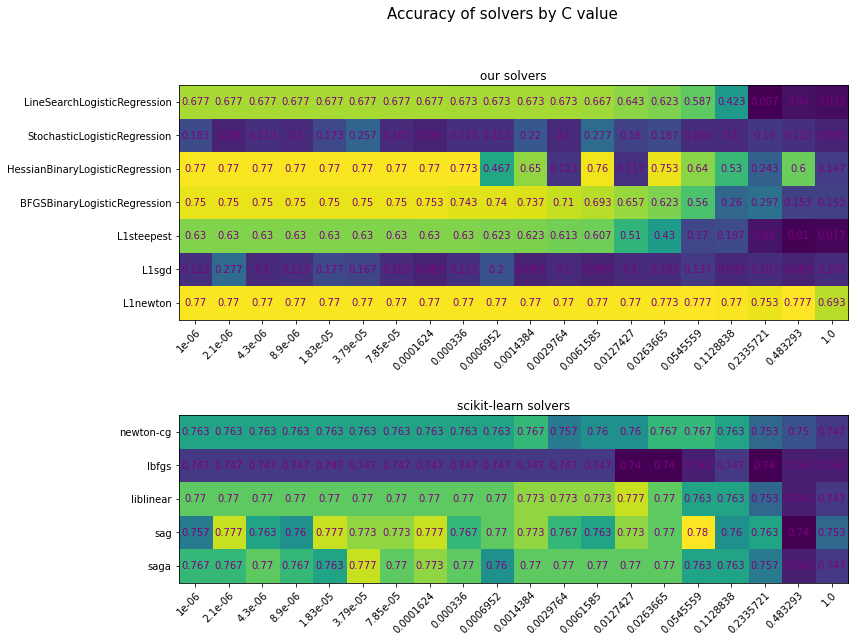

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Accuracy of solvers by C value',fontsize=15)

ax[0].set_title('our solvers')   
ax[0].imshow(accuracies)
ax[0].set_yticks(np.arange(NS))
ax[0].set_xticks(np.arange(NC))
ax[0].set_yticklabels([solver.__name__ for solver in solvers] + custom_solvers);
ax[0].set_xticklabels(Cvals.round(7));
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");
for i in range(NS):
    for j in range(NC):
        text = ax[0].text(j, i, accuracies[i, j].round(3),
                       ha="center", va="center", color="purple")

ax[1].set_title('scikit-learn solvers')   
ax[1].imshow(accuracies_sl)
ax[1].set_yticks(np.arange(NS_sl))
ax[1].set_xticks(np.arange(NC_sl))
ax[1].set_yticklabels(solvers_sl);
ax[1].set_xticklabels((1/Cvals_sl).round(7));
ax[1].invert_xaxis()
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");
for i in range(NS_sl):
    for j in range(NC_sl):
        text = ax[1].text(j, i, accuracies_sl[i, j].round(3),
                       ha="center", va="center", color="purple")      

Comparing our solvers and scikit-learn across the whole grid, we notice a few things:
* Our accuracies ranged from 0.01 to 0.777
* Scikit's accuracies ranged from 0.74 to 0.78
* In other words, the accuracy of our solvers varied wildly and was often poor. Scikit's accuracy was consistently high across the whole grid.
* Our SGD solvers - with either L1 or L2 regularization - were the weakest of all solvers.
* Newton's method, especially with our custom L1 regularization, performed the best out of our solvers and with good consistency.
* Scikit's "sag" (stochastic average gradient) solver had the highest accuracies, reaching 0.78
* The "**splotchiness**" of each row indicates the randomness of the method. Our BFGS solver shows a very smooth change in accuracy as C is varied, while scikit's sag solver shows much variation in accuracy due to its stochastic nature.

We believe our usage of gridsearch to select a model and the parameter C is justified. While each model may have its own ideal range for the value of C, we chosen a logarithmic grid in C to accomodate this.

In [ ]:
S_best,C_best = np.unravel_index(np.argmax(accuracies), accuracies.shape)
S_best_sl,C_best_sl = np.unravel_index(np.argmax(accuracies_sl), accuracies_sl.shape)

our_solver_names = [solver.__name__ for solver in solvers] + custom_solvers

print('Our solvers:')
print('\tBest accuracy in grid:',accuracies.max())
print('\tSolver used:',our_solver_names[S_best])
print('\tC value used:',Cvals[C_best])
print('\tTime of best:',times[S_best,C_best]*-1000.,'ms')

print("Scikit's solvers:")
print('\tBest accuracy in grid:',accuracies_sl.max())
print('\tSolver used:',solvers_sl[S_best_sl])
print('\tC value used:',Cvals[C_best_sl])
print('\tTime of best:',times[S_best_sl,C_best_sl]*-1000.,'ms')


Our solvers:
	Best accuracy in grid: 0.7766666666666666
	Solver used: L1newton
	C value used: 0.05455594781168514
	Time of best: 3.5911440008931095 ms
Scikit's solvers:
	Best accuracy in grid: 0.78
	Solver used: sag
	C value used: 1.8329807108324375e-05
	Time of best: 0.29926800016255584 ms


The best of our solvers and the scikit solvers are shown above, along with times and the corresponding C values.

Among our solvers, the custom "L1newton" solver did the best, with a corresponding C value of 0.05455.

**Data snooping** is likely to have some effect here as we have only 300 rows in our test set. This will  be less of an issue on a full-scale training set; recall we are only using 10 of 151 intents.

###Model selection

As discussed in the overview, model *accuracy* is our primary concern. Models will likely be pretrained and may be gradually adapted to the user's speech patterns, which could take weeks or more.

However, the choice is very easy in this case. Scikit's "sag" solver model was marginally more accurate and 12 times faster to train than our best model, "L1newton".

For these reasons and those discussed in the overview, we would choose scikit's "sag" solver to be used in a **deployed machine learning model**.

###Custom "L1newton" vs. Scikit's "sag": Confusion matrix

We visualize the accuracy of L1newton and sag via confusion matrices:

In [ ]:
lr_best = CustomMultiClassLogisticRegression(eta=1, iterations=10,
                                        C=0.05455594781168514, technique='L1newton')
lr_best_sl = LogisticRegression(n_jobs=1,max_iter=10,C=1/0.0000183298071083,
                                solver='sag',multi_class='ovr',penalty='l2')
lr_best.fit(X_train,y_train);
lr_best_sl.fit(X_train,y_train);

In [ ]:
yhat = lr_best.predict(X_test)
yhat_sl = lr_best_sl.predict(X_test)
print('our best:',accuracy_score(y_test,yhat))
print('scikit best:',accuracy_score(y_test,yhat_sl))

our best: 0.7766666666666666
scikit best: 0.7866666666666666


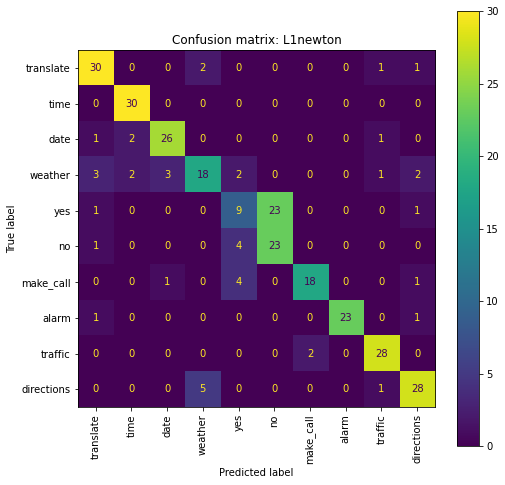

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm   = confusion_matrix(np.array(y_test), yhat, intents_keep)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=intents_keep)
disp.plot(xticks_rotation = 'vertical', include_values = True)
disp.figure_.set_size_inches(8,8)
disp.ax_.set_title('Confusion matrix: L1newton');

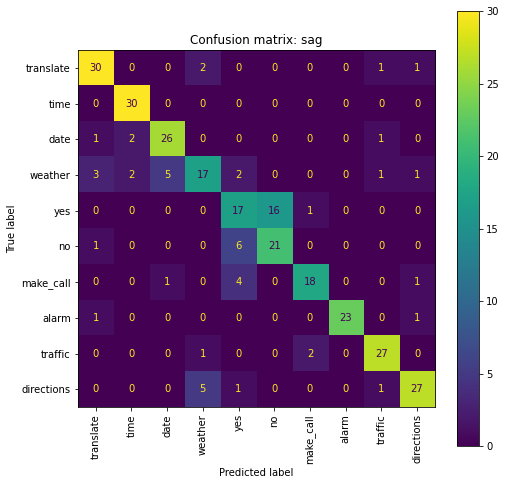

In [ ]:
cm   = confusion_matrix(np.array(y_test), yhat_sl, intents_keep)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=intents_keep)
disp.plot(xticks_rotation = 'vertical', include_values = True)
disp.figure_.set_size_inches(8,8)
disp.ax_.set_title('Confusion matrix: sag');

One notable difference between these confusion matrices is the treatment of "yes" and "no."

When L1newton predicts "no," 50% of the time it is truly "no" and 50% of the time it is truly "yes."

sag does noticably better job with "no" queries. When sag predicts "no," it is over 56% accurate.

# Exceptional Work

We use mean square error (MSE) as our objective function:

$$l(\mathbf{w}) = \frac{1}{M}\sum_i{(y^{(i)} - g(\mathbf{w}^T\mathbf{x}^{(i)}))^2}$$

So that the gradient is given by

$$
\begin{align}
\frac{\delta}{\delta w_j}l(\mathbf{w})
&= \frac{-2}{M}
\sum_i{(y^{(i)} - g(\mathbf{w}^T\mathbf{x}^{(i)}))}
g(\mathbf{w}^T\mathbf{x}^{(i)}) (1 - g(\mathbf{w}^T\mathbf{x}^{(i)})) x_j^{(i)}\\
&=\frac{-2}{M}
\sum_i{(y - g) g (1 - g) x_j^{(i)}}\\
&=\frac{-2}{M}
\sum_i{(yg-yg^2-g^2+g^3)x_j^{(i)}}
\end{align}
$$

And the entries of the hessian are given by

$$
\begin{align}
\frac{\delta}{\delta w_k}\frac{\delta}{\delta w_j}l(\mathbf{w})
&= \frac{-2}{M} \frac{\delta}{\delta w_k}
\sum_i{(yg-yg^2-g^2+g^3)x_j^{(i)}}\\
&= \frac{-2}{M}
\sum_i{(y-2yg-2g+3g^2)g(1-g)x_j^{(i)}x_k^{(i)}}\\
\end{align}
$$

In [ ]:
%%time
from numpy.linalg import pinv
class L1MSEHessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        # g = np.maximum(0,g)
        hessian = X.T @ np.diag((y-2*y*g-2*g+3*g**2)*g*(1-g)) @ X # calculate the hessian
        if np.isnan(hessian).any(): hessian = np.zeros_like(hessian) # prevent nan / overflow errors

        ydiff = (y-g)*g*(1-g) # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
        
        return pinv(hessian) @ gradient

CPU times: user 62 µs, sys: 0 ns, total: 62 µs
Wall time: 70.3 µs


We visualize the accuracy as before with a grid of C values:

In [ ]:
Cvals_mse = np.logspace(-6,0,20)
NC_mse    = len(Cvals_sl)

accuracies_mse = np.zeros(shape=NC_mse)
times_mse = np.zeros_like(accuracies_mse)

for j,C in enumerate(Cvals_mse):
    start = timeit.timeit()#START
    lr_mse = MultiClassLogisticRegression(eta=1, iterations=10, C=C,
                                          solver=L1MSEHessianBinaryLogisticRegression)
    lr_mse.fit(X_train,y_train)
    yhat_mse = lr_mse.predict(X_test)
    accuracies_mse[j] = accuracy_score(y_test,yhat_mse)
    end = timeit.timeit()#END
    times_mse[j]=end-start

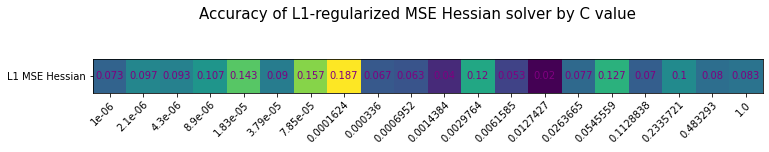

In [ ]:
fig,ax = plt.subplots(figsize=(12,2))
fig.suptitle('Accuracy of L1-regularized MSE Hessian solver by C value',fontsize=15)
 
ax.imshow(accuracies_mse[np.newaxis,:])
ax.set_yticks([0])
ax.set_xticks(np.arange(NC_mse))
ax.set_yticklabels(['L1 MSE Hessian']);
ax.set_xticklabels(Cvals_mse.round(7));
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");
for j in range(NC_mse):
    text = ax.text(j, 0, accuracies_mse[j].round(3),
                    ha="center", va="center", color="purple")

It's quite easy to say that maximum likelihood is the preferable objective function.

The matrix computations were less stable with this new scheme, requiring us to implement a nan check on the Hessian.

Our previous Heassian solvers had good accuracy and were stable as C varied. Neither is the case for this MSE implementation.